In [241]:
import pandas as pd
from sklearn import preprocessing
import argparse
import numpy as np
import scipy
import csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from time import time
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.grid_search import ParameterGrid
import pylab as pl
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import ParameterGrid
from scipy import interp
from sklearn.cross_validation import StratifiedKFold
import math
import sys
import itertools
%matplotlib inline

In [83]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [242]:
INPUT_PRICE = 25
INPUT_COST = 10
if INPUT_PRICE - INPUT_COST <= 0:
    print("Invalid input")

               age      campaign         pdays      previous  emp.var.rate  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406      2.567593    962.475454      0.172963      0.081886   
std       10.42125      2.770014    186.910907      0.494901      1.570960   
min       17.00000      1.000000      0.000000      0.000000     -3.400000   
25%       32.00000      1.000000    999.000000      0.000000     -1.800000   
50%       38.00000      2.000000    999.000000      0.000000      1.100000   
75%       47.00000      3.000000    999.000000      0.000000      1.400000   
max       98.00000     56.000000    999.000000      7.000000      1.400000   

       cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count    41188.000000   41188.000000  41188.000000  41188.000000  
mean        93.575664     -40.502600      3.621291   5167.035911  
std          0.578840       4.628198      1.734447     72.251528  
min         92.201000     -50

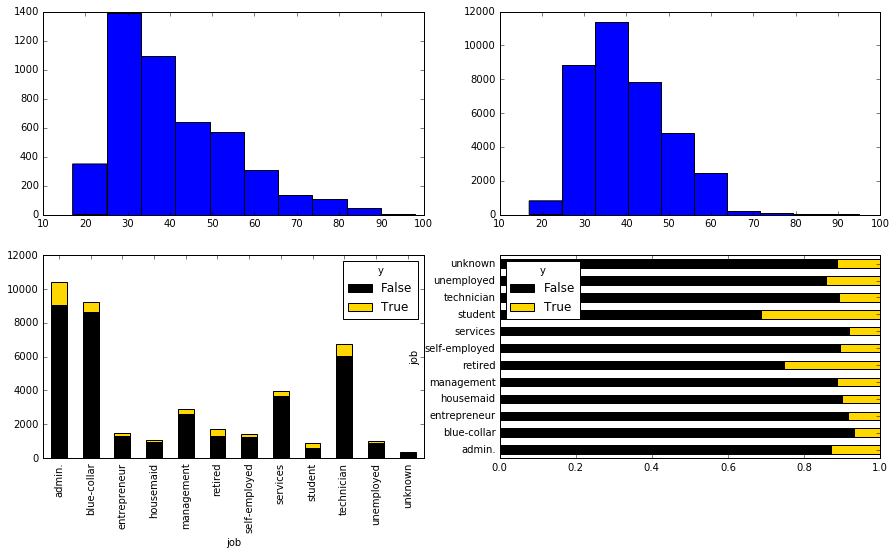

In [35]:
data = pd.read_csv('bank-additional-full.csv', delimiter=';')
# remove feature 'duration'
data = data.drop('duration', 1)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,8))
data[data.y == 'yes'].age.hist(grid=False, ax=axs[0, 0])
data[data.y == 'no'].age.hist(grid=False, ax=axs[0, 1])

print(data.describe())
# Label Encoding. Encode y (target) first, then we can visualize the data
lab = preprocessing.LabelEncoder()
data.y = lab.fit_transform(data.y)

# visualize the data
yes_counts = pd.crosstab([data.job], data.y.astype(bool))
yes_counts.plot(kind='bar', stacked=True, color=['black', 'gold'], grid=False, ax=axs[1, 0])

yes_counts.div(yes_counts.sum(1).astype(float), axis=0).plot(kind='barh', stacked=True, color=['black','gold'], ax=axs[1, 1])

Reduced dataset shape: (41188, 2)


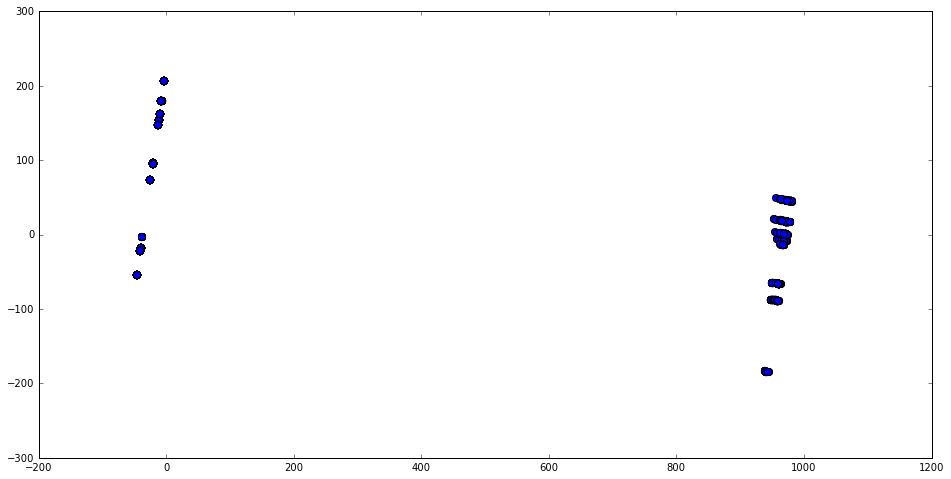

Meaning of the 2 components:
0.002 x age + -0.001 x campaign + -0.987 x pdays + 0.002 x previous + -0.003 x emp.var.rate + -0.000 x cons.price.idx + 0.002 x cons.conf.idx + -0.003 x euribor3m + -0.163 x nr.employed
0.001 x age + -0.005 x campaign + 0.163 x pdays + 0.002 x previous + -0.020 x emp.var.rate + -0.005 x cons.price.idx + -0.011 x cons.conf.idx + -0.023 x euribor3m + -0.986 x nr.employed


In [86]:
# numeric_features = ['age', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
numeric_features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
data_for_cluster = data.loc[:, numeric_features].values
pca = PCA(n_components=2)
pca.fit(data_for_cluster)
data_for_cluster_reduced = pca.transform(data_for_cluster)
print("Reduced dataset shape:", data_for_cluster_reduced.shape)

plt.figure(figsize=(16,8))
plt.scatter(data_for_cluster_reduced[:, 0], data_for_cluster_reduced[:, 1], s=50)
plt.show()

print("Meaning of the 2 components:")
for component in pca.components_:
    print(" + ".join("%.3f x %s" % (value, name) 
                     for value, name in zip(component, numeric_features)))

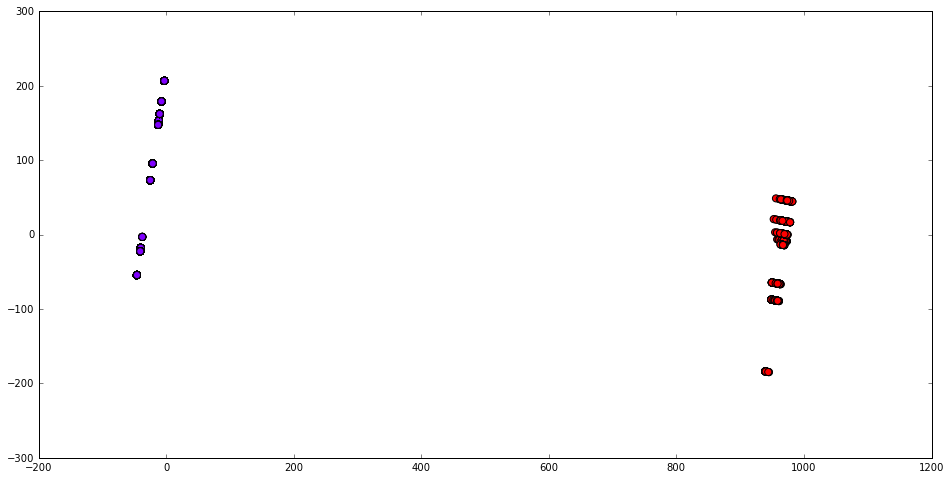

In [90]:
k_means = KMeans(n_clusters=2)
k_means.fit(data_for_cluster)
y_pred = k_means.predict(data_for_cluster)

plt.figure(figsize=(16,8))
plt.scatter(data_for_cluster_reduced[:, 0], data_for_cluster_reduced[:, 1], c=y_pred,
           cmap='rainbow', s=50)
plt.show()

In [157]:
# Label Encoding
data.job = lab.fit_transform(data.job)
data.marital = lab.fit_transform(data.marital)
data.education = lab.fit_transform(data.education)
data.default = lab.fit_transform(data.default)
data.housing = lab.fit_transform(data.housing)
data.loan = lab.fit_transform(data.loan)
data.contact = lab.fit_transform(data.contact)
data.month = lab.fit_transform(data.month)
data['day_of_week'] = lab.fit_transform(data['day_of_week'])
data.poutcome = lab.fit_transform(data.poutcome)

In [158]:
features = data.as_matrix() # features shape: (41188, 21)
target = features[:, 20]
features_numeric = features[:, 0:20] # shape: (41188, 20) (index 20 won't be included)

In [159]:
print(features_numeric[0])
# [  5.60000000e+01   3.00000000e+00   1.00000000e+00   0.00000000e+00
#    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
#    6.00000000e+00   1.00000000e+00   2.61000000e+02   1.00000000e+00
#    9.99000000e+02   0.00000000e+00   1.00000000e+00   1.10000000e+00
#    9.39940000e+01  -3.64000000e+01   4.85700000e+00   5.19100000e+03]

# One-k-scheme encoding
from sklearn.preprocessing import OneHotEncoder
cat_indices = np.array([[1,2,3,4,5,6,7,8,9,14]]) # [[ 1  2  3  4  5  6  7  8  9 14]]

enc = OneHotEncoder(categorical_features = cat_indices)
encoded_features1 = enc.fit_transform(features_numeric)
print(enc.n_values_)
# [12  4  8  3  3  3  2 10  5  3]

print(enc.feature_indices_)
# [ 0 12 16 24 27 30 33 35 45 50 53]

print(len(encoded_features1.toarray()[0]))
# 63

print(encoded_features1.toarray()[0]) # print the first row of data (it has rearranged category features in front of all continuous features)
# [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00(housemaid, which is encoded as 3)
#    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
#    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
#    0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
#    1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
#    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
#    1.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
#    0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
#    0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
#    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
#    0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
#    0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
#    0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
#    0.00000000e+00   5.60000000e+01   2.61000000e+02   1.00000000e+00
#    9.99000000e+02   0.00000000e+00   1.10000000e+00   9.39940000e+01
#   -3.64000000e+01   4.85700000e+00   5.19100000e+03]


[  5.60000000e+01   3.00000000e+00   1.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
   6.00000000e+00   1.00000000e+00   2.61000000e+02   1.00000000e+00
   9.99000000e+02   0.00000000e+00   1.00000000e+00   1.10000000e+00
   9.39940000e+01  -3.64000000e+01   4.85700000e+00   5.19100000e+03]
[12  4  8  3  3  3  2 10  5  3]
[ 0 12 16 24 27 30 33 35 45 50 53]
63
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+

In [160]:
# Splitting data
X_train, X_test, Y_train, Y_test = train_test_split(encoded_features1.todense(), target, test_size=0.4, random_state=0)
print(X_train.shape)
print(X_test.shape)

(24712, 63)
(16476, 63)


In [170]:
def run_classifier(classifier_id):    
    classifiers = (None, RandomForestClassifier, SVC, LogisticRegression, DecisionTreeClassifier)

    grid_RF = [{'max_depth': [5, 10, 15], 'criterion': ['entropy', 'gini'], 'n_estimators': [50, 100, 250], 'class_weight': ['balanced']}]
    
    # TODO: do we need to include linear kernel?
    grid_SVC = [{'kernel': ['rbf', 'linear'], 'C': [0.1, 1.0, 100.0], 'gamma': [0.001, 0.1, 10.0], 'class_weight': ['balanced'], 'probability': [True]}]
    
    # TODO: scale every predictor variable with maximum absolute value first, then train the model
    grid_LR = [{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': ['balanced']}]

    grid_DT = [{'criterion': ['entropy', 'gini'], 'max_depth': [5, 10, 15]}]

    grids = (None, grid_RF, grid_SVC, grid_LR, grid_DT)
    grid_obj = grids[classifier_id]
    cls_obj = classifiers[classifier_id]

    best_param = None
    best_score = None
    best_model = None
    print ("Performing cross validation using parameter grid...")
    for one_param in ParameterGrid(grid_obj):
        cls = cls_obj(**one_param)

        one_score = cross_val_score(cls, X_train, Y_train, cv=5, scoring='roc_auc')
        mscore = one_score.mean()

#         print ("param=%s, score=%.6f" % (repr(one_param),mscore))

        if ( best_score is None or best_score < mscore): 
            best_param = one_param
            best_score = mscore
            best_model = cls
    
    print ("Best score for Cross Validation: %.6f" % best_score)
    print("Best param: %s" % repr(best_param))

    ### ROC
    classifier_name_list = (None, "Random Forest", "SVM", "Logistic Regression", "Decision Trees")
    best_model.fit(X_train, Y_train)
    
    # len(best_model.feature_importances_) = 63 (there are 63 features after encoding)
#     print("best_model.feature_importances_: %s" % repr(best_model.feature_importances_))
    
    # TODO: Which approach should we use? by min. distance or by cost?
    best_params = get_best_model_params(best_model, X_train, Y_train, classifier_name_list[classifier_id])
    print("(best_fpr, best_tpr, best_threshold, best_fpr_by_cost, best_tpr_by_cost, best_threshold_by_cost) = ")
    print(best_params)
    
    predict_test(best_model, X_test, Y_test, classifier_name_list[classifier_id], best_params)

    
def predict_test(best_model, x_data, y_data, classifier_name, best_params):
    probas_ = best_model.predict_proba(x_data) # len(probas_) = size of testing set
#     print("probas_ = ")
#     print(probas_)    
    
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_data, probas_[:, 1]) # pick prob. of yes(encoded as 1)(corresponds to index 1)
#     print("=============")
#     print("length of fpr = " + str(len(fpr))) # 237
#     print(fpr)
#     print("length of tpr = " + str(len(tpr))) # 237
#     print(tpr)
#     print("length of thresholds = " + str(len(thresholds))) # 237
#     print(thresholds)
#     print("=============")    
    roc_auc = auc(fpr, tpr)
    print("Area under the ROC curve : %f" % roc_auc)    
    plot_roc_curve(fpr, tpr, roc_auc, classifier_name)    
    
    # assess the model based on best_threshold
    best_threshold = best_params[2]    
    tp_plus_fn = 0 # actual yes
    tn_plus_fp = 0 # actual no
    tp = 0
    fp = 0
    for item in zip(y_data, probas_[:, 1]):
        if item[0] == 1.0:
            tp_plus_fn += 1
        else:
            tn_plus_fp += 1
        
        if item[1] >= best_threshold:
            # predict as positive            
            if item[0] == 1.0:
                tp += 1
            else:
                fp += 1
    test_fpr = fp / tn_plus_fp
    test_tpr = tp / tp_plus_fn
    print("(test_fpr, test_tpr) = ")
    print((test_fpr, test_tpr))
    cost = fp * INPUT_COST - tp * (INPUT_PRICE - INPUT_COST)
    print("fp = %s" % str(fp))
    print("tp = %s" % str(tp))    
    print("Using this best model to do predictions on test set, the profit of the bank is %s USD.\n" % str(-1 * cost))
    
    
    # assess the model based on best_threshold_by_cost (approach is the same as above)
    best_threshold_by_cost = best_params[5]    
    tp_plus_fn = 0 # actual yes
    tn_plus_fp = 0 # actual no
    tp = 0
    fp = 0
    for item in zip(y_data, probas_[:, 1]):
        if item[0] == 1.0:
            tp_plus_fn += 1
        else:
            tn_plus_fp += 1
        
        if item[1] >= best_threshold_by_cost:
            # predict as positive            
            if item[0] == 1.0:
                tp += 1
            else:
                fp += 1
    test_fpr_by_cost = fp / tn_plus_fp
    test_tpr_by_cost = tp / tp_plus_fn
    print("(test_fpr_by_cost, test_tpr_by_cost) = ")
    print((test_fpr_by_cost, test_tpr_by_cost))
    cost = fp * INPUT_COST - tp * (INPUT_PRICE - INPUT_COST)
    print("fp = %s" % str(fp))
    print("tp = %s" % str(tp))
    print("Using this best model to do predictions on test set, the profit of the bank is %s USD.\n" % str(-1 * cost))
    
    
def get_best_model_params(best_model, x_data, y_data, classifier_name):
    probas_ = best_model.predict_proba(x_data) # len(probas_) = size of training set
    
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_data, probas_[:, 1]) # pick prob. of yes(encoded as 1)(corresponds to index 1)
    
    roc_auc = auc(fpr, tpr)
    print("Area under the ROC curve : %f" % roc_auc)    
    plot_roc_curve(fpr, tpr, roc_auc, classifier_name)

    
    # find best params
    best_fpr = None
    best_tpr = None
    best_threshold = None
    min_distance = sys.maxsize
    for item in zip(fpr, tpr, thresholds):
        distance = math.sqrt(math.pow(item[0], 2) + math.pow(item[1] - 1, 2))
        if min_distance > distance:
            min_distance = distance
            best_fpr = item[0]
            best_tpr = item[1]
            best_threshold = item[2]
    
    
    # find best params by cost
    tp_plus_fn = 0 # actual yes
    tn_plus_fp = 0 # actual no    
    for item in y_data:
        if item == 1.0:
            tp_plus_fn += 1
        else:
            tn_plus_fp += 1
    
    best_fpr_by_cost = None
    best_tpr_by_cost = None
    best_threshold_by_cost = None
    min_cost = sys.maxsize
    for item in zip(fpr, tpr, thresholds):
        cost = tn_plus_fp * item[0] * INPUT_COST - tp_plus_fn * item[1] * (INPUT_PRICE - INPUT_COST)
        if min_cost > cost:
            min_cost = cost
            best_fpr_by_cost = item[0]
            best_tpr_by_cost = item[1]
            best_threshold_by_cost = item[2]
    
    
    return (best_fpr, best_tpr, best_threshold, best_fpr_by_cost, best_tpr_by_cost, best_threshold_by_cost)
    

def plot_roc_curve(fpr, tpr, roc_auc, classifier_name):
    pl.clf()
    pl.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    pl.plot([0, 1], [0, 1], 'k--')
    pl.xlim([0.0, 1.0])
    pl.ylim([0.0, 1.0])
    pl.xlabel('False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.title('Receiver operating characteristic- %s' % classifier_name)
    pl.legend(loc="lower right")
    pl.show()    

Performing cross validation using parameter grid...
Best score for Cross Validation: 0.939286
Best param: {'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 250, 'class_weight': 'balanced'}
Area under the ROC curve : 0.994178


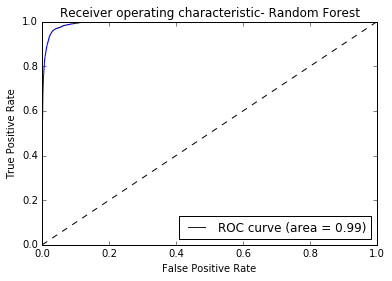

(best_fpr, best_tpr, best_threshold, best_fpr_by_cost, best_tpr_by_cost, best_threshold_by_cost) = 
(0.035810533047092676, 0.96452642781128062, 0.55582489747201624, 0.020828575343717171, 0.93118126995388439, 0.6127070994802426)
Area under the ROC curve : 0.945232


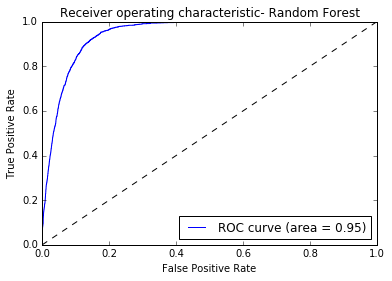

(test_fpr, test_tpr) = 
(0.06236779256226544, 0.6968698517298187)
fp = 914
tp = 1269
Using this best model to do predictions on test set, the profit of the bank is 9895 USD.

(test_fpr_by_cost, test_tpr_by_cost) = 
(0.043875810303650634, 0.5771554091158704)
fp = 643
tp = 1051
Using this best model to do predictions on test set, the profit of the bank is 9335 USD.



In [171]:
run_classifier(1)

Performing cross validation using parameter grid...
Best score for Cross Validation: 0.929291
Best param: {'criterion': 'entropy', 'max_depth': 5}
Area under the ROC curve : 0.936357


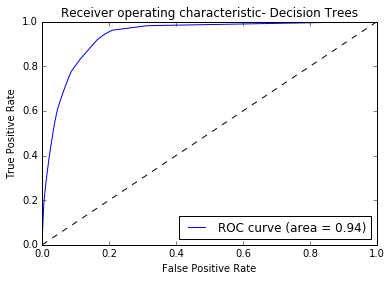

(best_fpr, best_tpr, best_threshold, best_fpr_by_cost, best_tpr_by_cost, best_threshold_by_cost) = 
(0.14899739642808205, 0.89286981199006743, 0.18133616118769882, 0.046498880920842277, 0.61120964881163531, 0.44800000000000001)
Area under the ROC curve : 0.930706


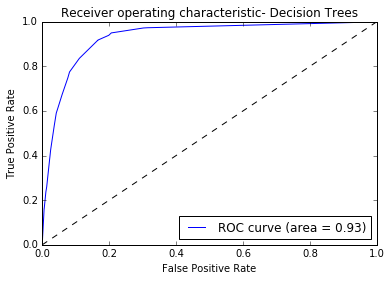

(test_fpr, test_tpr) = 
(0.1501194131695667, 0.8929159802306426)
fp = 2200
tp = 1626
Using this best model to do predictions on test set, the profit of the bank is 2390 USD.

(test_fpr_by_cost, test_tpr_by_cost) = 
(0.04605936540429888, 0.6090060406370126)
fp = 675
tp = 1109
Using this best model to do predictions on test set, the profit of the bank is 9885 USD.



In [172]:
run_classifier(4)

Performing cross validation using parameter grid...
Best score for Cross Validation: 0.935835
Best param: {'C': 0.1, 'class_weight': 'balanced'}
Area under the ROC curve : 0.937273


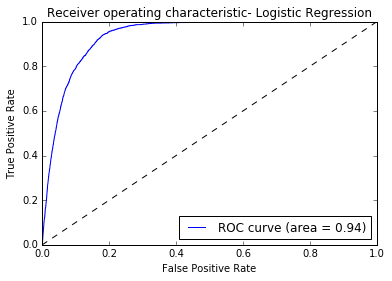

(best_fpr, best_tpr, best_threshold, best_fpr_by_cost, best_tpr_by_cost, best_threshold_by_cost) = 
(0.1642077376330334, 0.91734657680028375, 0.43246855338842316, 0.062028959027999819, 0.66264632848527849, 0.78666365635947044)
Area under the ROC curve : 0.938595


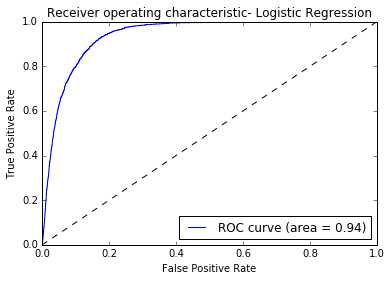

(test_fpr, test_tpr) = 
(0.1591265779597407, 0.9093904448105437)
fp = 2332
tp = 1656
Using this best model to do predictions on test set, the profit of the bank is 1520 USD.

(test_fpr_by_cost, test_tpr_by_cost) = 
(0.06141248720573183, 0.6781987918725975)
fp = 900
tp = 1235
Using this best model to do predictions on test set, the profit of the bank is 9525 USD.



In [173]:
run_classifier(3) # balanced class weight

Performing cross validation using parameter grid...
Best score for Cross Validation: 0.917436
Best param: {'probability': True, 'C': 0.1, 'gamma': 0.001, 'class_weight': 'balanced', 'kernel': 'linear'}
Area under the ROC curve : 0.921214


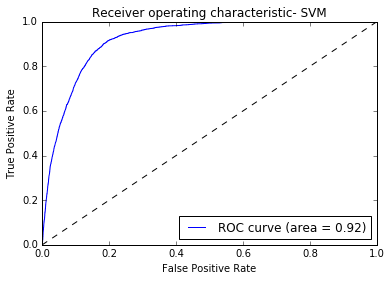

(best_fpr, best_tpr, best_threshold, best_fpr_by_cost, best_tpr_by_cost, best_threshold_by_cost) = 
(0.15799570639017038, 0.86732884001418942, 0.09232839759491937, 0.051203581053304706, 0.52926569705569348, 0.42059185040020119)
Area under the ROC curve : 0.924327


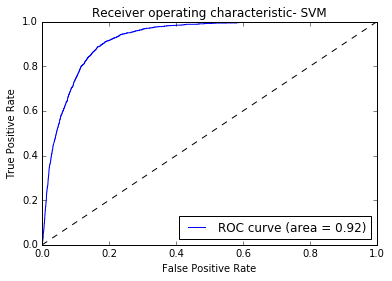

(test_fpr, test_tpr) = 
(0.15175707949505288, 0.8638110928061504)
fp = 2224
tp = 1573
Using this best model to do predictions on test set, the profit of the bank is 1355 USD.

(test_fpr_by_cost, test_tpr_by_cost) = 
(0.04756055953599454, 0.528281164195497)
fp = 697
tp = 962
Using this best model to do predictions on test set, the profit of the bank is 7460 USD.



In [174]:
run_classifier(2)

In [49]:
print(target)

[ 0.  0.  0. ...,  0.  1.  0.]


In [50]:
print(Y_test)

[ 1.  0.  0. ...,  0.  0.  0.]


In [85]:
x = np.linspace(1, 10, 10)
print(x)

[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.]


In [45]:
dates = pd.date_range('20130101', periods=6)
df = pd.DataFrame(np.random.randn(6,4), index=[0,1,2,3,4,5], columns=list('ABCD'))
print(df)
print(df.loc[:, ['B', 'D']])
# df['e'] = Series(['a', 'b', 'c', 'd', 'e', 'f'], index=df.index)

          A         B         C         D
0 -0.706521  1.115965  0.781267  0.499550
1 -0.425632 -0.481722  2.068476  0.446576
2  0.147854 -0.541245 -0.207240  0.625759
3  0.615624  0.082600  1.425294  0.634087
4  0.939297  1.060866 -1.245508  0.687863
5  0.573308  1.151740 -0.268962 -0.614507
          B         D
0  1.115965  0.499550
1 -0.481722  0.446576
2 -0.541245  0.625759
3  0.082600  0.634087
4  1.060866  0.687863
5  1.151740 -0.614507
